In [ ]:
!pip install h2o
import pandas as pd
import matplotlib.pyplot as plt

import h2o
h2o.init()

     |████████████████████████████████| 164.6MB 85kB/s 
  Created wheel for h2o: filename=h2o-3.32.0.4-py2.py3-none-any.whl size=164670979 sha256=0a9531b73826e731016940526e3641f3c42672703e6127204974b3db45b4405e
  Stored in directory: /root/.cache/pip/wheels/65/f4/0d/c9bb958d70c2e015c968cb91cbd7f1b486933056d422337d75
Successfully built h2o
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.10" 2021-01-19; OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpddm1w3e3
  JVM stdout: /tmp/tmpddm1w3e3/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpddm1w3e3/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting t

H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,1 month and 12 days
H2O_cluster_name:,H2O_from_python_unknownUser_uzs7oy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [ ]:
df = pd.read_csv(
  '/content/data_stroke.csv')
data = h2o.import_file('/content/data_stroke.csv')
data['Surv'] = data['Surv'].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
data.describe()

Rows:113
Cols:9




,Gender,Age,AF,Localisation,AMI_Unst.ang,GFR,Surv,Q_non_Q,DM
type,enum,int,enum,enum,enum,int,enum,enum,enum
mins,,56.0,,,,9.0,,,
mean,,77.01769911504424,,,,43.00000000000002,,,
maxs,,98.0,,,,98.0,,,
sigma,,8.869069749984408,,,,20.34128454997022,,,
zeros,,0,,,,0,,,
missing,0,0,0,0,0,0,0,59,0
0,male,56.0,No_AF,Left_car,AMI,14.0,death,non_Q,Diabetes
1,male,59.0,No_AF,Left_car,Unst_ang,98.0,alive,,No_Diabetes
2,female,86.0,AF,Left_car,AMI,57.0,death,non_Q,Diabetes


In [ ]:
data['Surv'].table()

Surv,Count
alive,52
death,61


In [ ]:
data['Gender'].table()

Gender,Count
female,83
male,30


In [ ]:
from h2o.automl import H2OAutoML
from h2o.estimators import H2OXGBoostEstimator

In [ ]:
# Set predictors and response variable
response = "Surv"
predictors = data.col_names.remove(response)


In [ ]:
# split
train, test = data.split_frame(seed = 1234, 
                                  ratios = [0.75], 
                                  destination_frames = ["train.hex", "test.hex"])

In [ ]:
train.col_names

['Gender',
 'Age',
 'AF',
 'Localisation',
 'AMI_Unst.ang',
 'GFR',
 'Surv',
 'Q_non_Q',
 'DM']

In [ ]:
stroke_xgb = H2OXGBoostEstimator(booster='dart',
                                  normalize_type="tree",
                                  seed=1234)

In [ ]:
stroke_xgb.train(x=predictors,
                  y=response,
                  training_frame=train,
                  validation_frame=test)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [ ]:
stroke_xgb.accuracy()

[[0.6939302682876587, 1.0]]

In [ ]:
stroke_xgb.confusion_matrix(valid=test)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38981395959854126: 


,,alive,death,Error,Rate
0,alive,10.0,4.0,0.2857,(4.0/14.0)
1,death,0.0,15.0,0.0,(0.0/15.0)
2,Total,10.0,19.0,0.1379,(4.0/29.0)


In [ ]:
stroke_xgb.auc(valid=test)

0.838095238095238

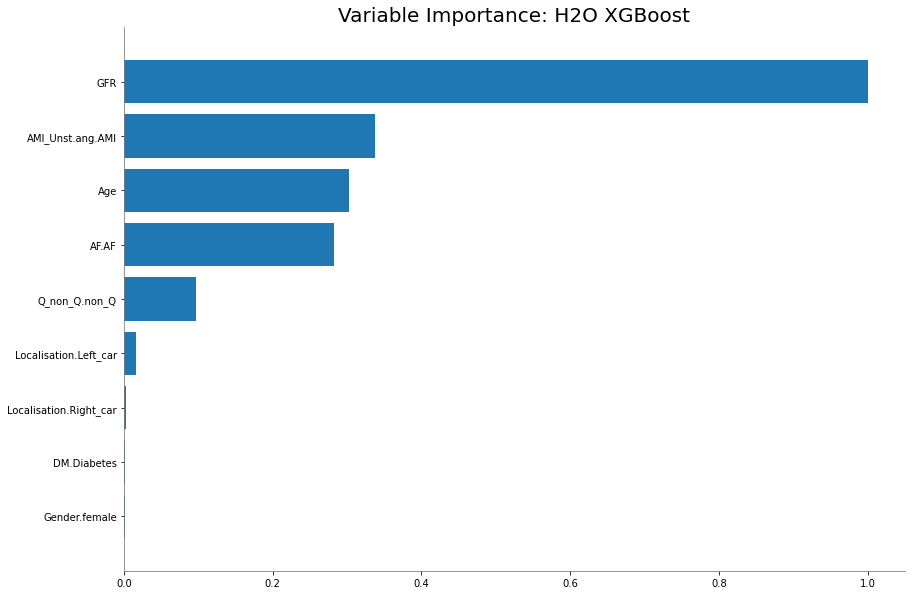

In [ ]:
stroke_xgb.varimp_plot()

In [ ]:
aml = H2OAutoML(max_models = 6, max_runtime_secs = 120, seed = 12345)
aml.train(x = predictors, y = response, training_frame = train, leaderboard_frame = test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [ ]:
lb = aml.leaderboard

In [ ]:
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_1_AutoML_20210314_080158,0.866667,0.460474,0.840542,0.142857,0.362449,0.131369
StackedEnsemble_BestOfFamily_AutoML_20210314_080158,0.842857,0.446959,0.704081,0.107143,0.354997,0.126023
StackedEnsemble_AllModels_AutoML_20210314_080158,0.838095,0.455212,0.700163,0.107143,0.370997,0.137639
XGBoost_3_AutoML_20210314_080158,0.828571,0.508935,0.811584,0.178571,0.405357,0.164314
DRF_1_AutoML_20210314_080158,0.82381,0.551078,0.738875,0.17619,0.406136,0.164946
GLM_1_AutoML_20210314_080158,0.780952,0.65419,0.705484,0.214286,0.43137,0.18608
XGBoost_1_AutoML_20210314_080158,0.692857,0.660492,0.586733,0.214286,0.465508,0.216698
XGBoost_2_AutoML_20210314_080158,0.5,0.692938,0.517241,0.5,0.499895,0.249895


In [ ]:
aml.varimp_heatmap


<bound method varimp_heatmap of <h2o.automl.autoh2o.H2OAutoML object at 0x7f6a1492ac90>>

In [ ]:
import scipy
from scipy import stats
x = df[df['Surv'] == 'death']['GFR']
y = df[df['Surv'] == 'alive']['GFR']


In [ ]:
y

In [ ]:
x.name, y.name = 'death', 'alive'

In [ ]:
res = stats.ttest_ind(x, y)
print('p-value: ', res[1])

p-value:  0.000291013320097493


In [ ]:
from h2o.estimators.coxph import H2OCoxProportionalHazardsEstimator

In [ ]:
data.col_names

In [ ]:
stroke_coxph = H2OCoxProportionalHazardsEstimator(
                                                 stop_column="GFR",
                                                 ties="breslow")
stroke_coxph.train(x=predictors,
            y=response,
            training_frame=train)

In [ ]:
pred = stroke_coxph.predict(test)

coxph prediction progress: |██████████████████████████████████████████████| 100%


In [ ]:
stroke_coxph.coefficients_table

In [ ]:
stroke_xgb.logloss(valid=test)

0.4710057299118354

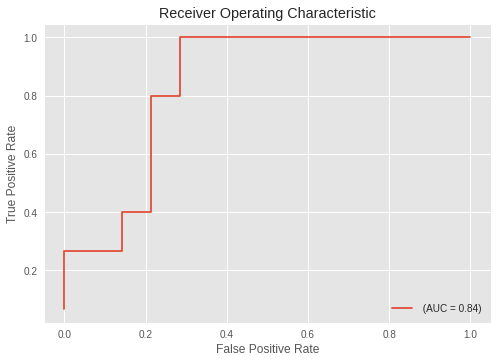

In [ ]:
import matplotlib.pyplot as plt  
matplotlib.style.use('ggplot')
import numpy as np
from sklearn import metrics
display = metrics.RocCurveDisplay(stroke_xgb.roc(valid=test)[0], stroke_xgb.roc(valid=test)[1], stroke_xgb.auc(valid=test), estimator_name='')
display.plot()
plt.title('Receiver Operating Characteristic')
plt.show() 

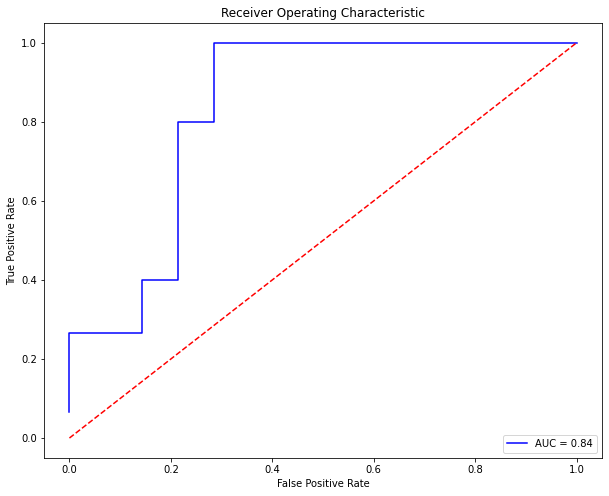

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
plt.title('Receiver Operating Characteristic')
plt.plot(stroke_xgb.roc(valid=test)[0], stroke_xgb.roc(valid=test)[1], 'b', label = 'AUC = %0.2f' % stroke_xgb.auc(valid=test))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()